In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random

from keras import layers
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras import models
from keras import optimizers
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import applications

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import glob
import os

Using TensorFlow backend.


In [2]:
train_folder_path = "./train"
train_file_names = os.listdir(train_folder_path)
random.shuffle(train_file_names)

validation_folder_path = "./test"
validation_file_names = os.listdir(validation_folder_path)
random.shuffle(validation_file_names)

width = 150
height = 150

In [3]:
train_targets = list()
train_full_paths = list()
for file_name in train_file_names:
        target = file_name[0]
        full_path = os.path.join(train_folder_path, file_name)
        train_full_paths.append(full_path)
        train_targets.append(target)
        
train_set = pd.DataFrame()
train_set['image_path'] = train_full_paths
train_set['target'] = train_targets

validation_targets = list()
validation_full_paths = list()
for file_name in validation_file_names:
        target = file_name[0]
        full_path = os.path.join(validation_folder_path, file_name)
        validation_full_paths.append(full_path)
        validation_targets.append(target)
        
validation_set = pd.DataFrame()
validation_set['image_path'] = validation_full_paths
validation_set['target'] = validation_targets

In [4]:
train_set.head(10)

,image_path,target
0,./train/o_205840.201318_I2540000.png,o
1,./train/o_210833.892686_I1840000.png,o
2,./train/h_111532.557739_I3310000.png,h
3,./train/h_111535.140103_I2480000.png,h
4,./train/h_111537.830493_I1630000.png,h
5,./train/h_111537.966481_I1580000.png,h
6,./train/o_210833.327894_I2020000.png,o
7,./train/h_111533.647333_I2960000.png,h
8,./train/h_111535.692102_I2300001.png,h
9,./train/o_210829.010315_I3400001.png,o


In [5]:
validation_set.head(10)

,image_path,target
0,./test/o_170715.340883_I2720000.png,o
1,./test/h_144927.690293_I2730000.png,h
2,./test/o_170717.048900_I3270000.png,o
3,./test/h_144926.870302_I2470000.png,h
4,./test/o_170718.286471_I3660000.png,o
5,./test/o_170713.148901_I2030000.png,o
6,./test/h_144926.897500_I2480000.png,h
7,./test/h_144927.543885_I2680000.png,h
8,./test/o_170717.116089_I3290000.png,o
9,./test/o_170714.937707_I2600001.png,o


Random Visualization of Training Data Samples

In [6]:
def get_side(img, side_type, side_size=5):
    height, width, channel=img.shape
    if side_type=="horizontal":
        return np.ones((height,side_size,  channel), dtype=np.float32)*255
        
    return np.ones((side_size, width,  channel), dtype=np.float32)*255

def show_gallery(show="all"):
    n=100
    counter=0
    images=list()
    vertical_images=[]
    rng_state = np.random.get_state()
    np.random.shuffle(train_full_paths)
    np.random.set_state(rng_state)
    np.random.shuffle(train_targets)
    for path, target in zip(train_full_paths, train_targets):
        if target!=show and show!="all":
            continue
        counter=counter+1
        if counter%100==0:
            break
        #Image loading from disk as JpegImageFile file format
        img=load_img(path, target_size=(width,height))
        #Converting JpegImageFile to numpy array
        img=img_to_array(img)
        
        hside=get_side(img, side_type="horizontal")
        images.append(img)
        images.append(hside)

        if counter%10==0:
            himage=np.hstack((images))
            vside=get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)
            
            images=list()

    gallery=np.vstack((vertical_images)) 
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])
    title = {"all":"All Classifications's",
             "h":"Healthy",
             "o":"Non-Healthy"}
    plt.title("100 Samples of {} Patients of the training set".format(title[show]))
    plt.imshow(gallery.astype(np.uint8))

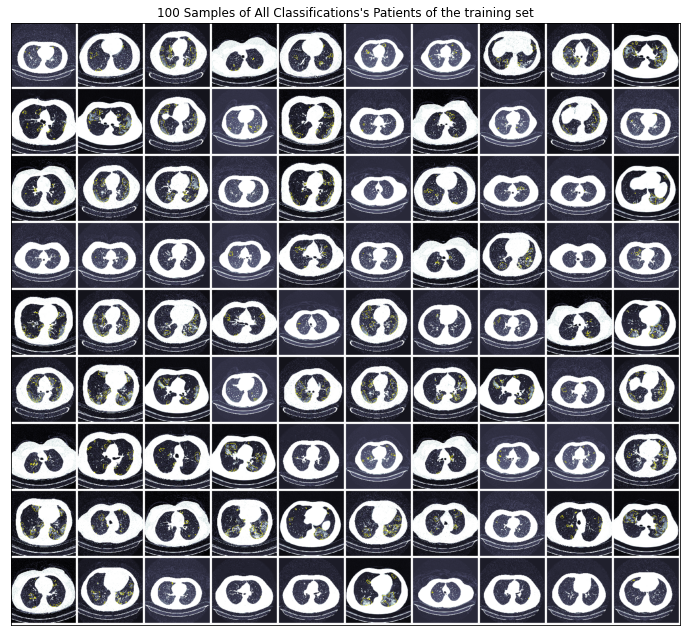

In [7]:
show_gallery("all")

In [8]:
target_counts=train_set['target'].value_counts()
print("Number of healthy patients in the training set:{}".format(target_counts['h']))
print("Number of non-healthy patients in the training set:{}".format(target_counts['o']))

Number of healthy patients in the training set:800
Number of non-healthy patients in the training set:800


In [9]:
target_counts=validation_set['target'].value_counts()
print("Number of healthy patients in the validation set:{}".format(target_counts['h']))
print("Number of non-healthy patients in the validation set:{}".format(target_counts['o']))

Number of healthy patients in the validation set:200
Number of non-healthy patients in the validation set:200


Building model from scratch

In [10]:
classifier= Sequential()

classifier.add(Convolution2D(32, (3, 3), input_shape=(height, width, 3), activation= 'relu'))
classifier.add(MaxPooling2D(pool_size= (2,2)))

classifier.add(Convolution2D(64, (3, 3), activation= 'relu'))
classifier.add(MaxPooling2D(pool_size= (2,2)))

classifier.add(Convolution2D(128, (3, 3), activation= 'relu'))
classifier.add(MaxPooling2D(pool_size= (2,2)))

classifier.add(Convolution2D(128, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size= (2,2)))

classifier.add(Flatten())

classifier.add(Dense(units= 512, activation= 'relu'))

classifier.add(Dense(units= 1, activation= 'sigmoid'))

classifier.compile(optimizer= 'adam', loss= 'binary_crossentropy' ,metrics= ['accuracy'])
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

Data Generator

In [11]:
batch_size = 16
train_datagen=ImageDataGenerator(
rotation_range=15,
rescale=1./255,
shear_range=0.1,
zoom_range=0.2,
horizontal_flip=False,
width_shift_range=0.1,
height_shift_range=0.1)

train_datagenerator=train_datagen.flow_from_dataframe(dataframe=train_set,
                                                     x_col="image_path",
                                                     y_col="target",
                                                     target_size=(width, height),
                                                     class_mode="binary",
                                                     batch_size=batch_size)

validation_datagen=ImageDataGenerator(rescale=1./255)
validation_datagenerator=validation_datagen.flow_from_dataframe(dataframe=validation_set,
                                                   x_col="image_path",
                                                   y_col="target",
                                                   target_size=(width, height),
                                                   class_mode="binary",
                                                   batch_size=batch_size)

Found 1600 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


See sample generated images

Found 1 validated image filenames belonging to 1 classes.


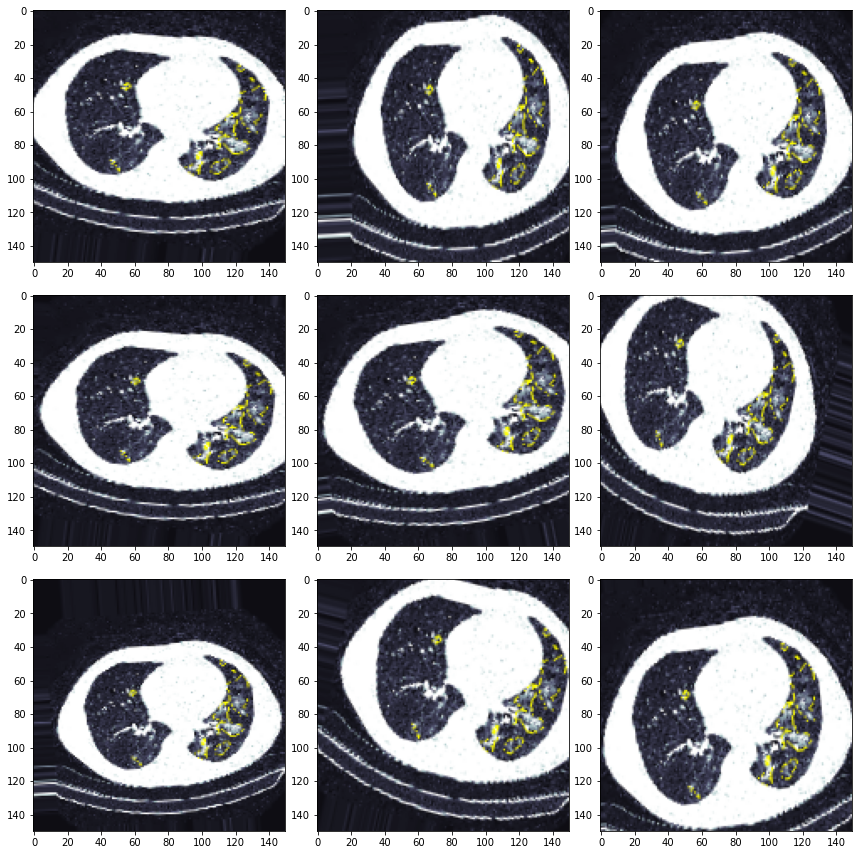

In [12]:
example_df = train_set.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(dataframe=example_df,
                                                     x_col="image_path",
                                                     y_col="target",
                                                     target_size=(width, height),
                                                     class_mode="categorical",
                                                     batch_size=batch_size)

plt.figure(figsize = (12,12))
for i in range(0, 9):
        plt.subplot(3, 3, i+1)
        for X_batch, Y_batch in example_generator:
            image = X_batch[0]
            plt.imshow(image)
            break
plt.tight_layout()
plt.show()

In [13]:
history = classifier.fit(train_datagenerator,
                         steps_per_epoch = train_set.shape[0]//batch_size,
                         epochs = 10,
                         validation_data = validation_datagenerator,
                         validation_steps = validation_set.shape[0]//batch_size)

Epoch 1/10
100/100 [==============================] - 108s 1s/step - loss: 0.4842 - accuracy: 0.7594 - val_loss: 0.7642 - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - 87s 871ms/step - loss: 0.1832 - accuracy: 0.9356 - val_loss: 0.0443 - val_accuracy: 0.9950
Epoch 3/10
100/100 [==============================] - 18s 180ms/step - loss: 0.0916 - accuracy: 0.9656 - val_loss: 0.1707 - val_accuracy: 0.8950
Epoch 4/10
100/100 [==============================] - 16s 161ms/step - loss: 0.0224 - accuracy: 0.9906 - val_loss: 0.2110 - val_accuracy: 0.9050
Epoch 5/10
100/100 [==============================] - 16s 162ms/step - loss: 0.0369 - accuracy: 0.9875 - val_loss: 0.0698 - val_accuracy: 0.9625
Epoch 6/10
100/100 [==============================] - 17s 175ms/step - loss: 0.0107 - accuracy: 0.9981 - val_loss: 0.0636 - val_accuracy: 0.9725
Epoch 7/10
100/100 [==============================] - 17s 173ms/step - loss: 0.0425 - accuracy: 0.9837 - val_loss: 0.3040 - val_accu

Saving model's parameters and Displaying curves of loss and accuracy during training

In [14]:
classifier.save('first_cnn.h5')

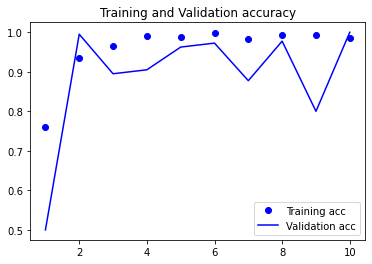

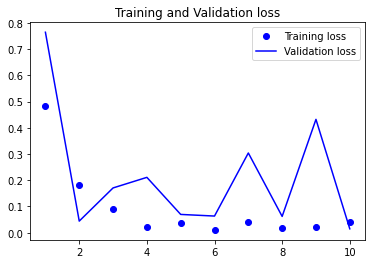

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()